In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
file_path = 'SpotifyFeatures.csv'
data = pd.read_csv(file_path)
data.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


### Vizualiing the data

In [2]:
# visulize "duplicate songs"(same trackid = same song)
data['track_id'].value_counts()

track_id
6sVQNUvcVFTXvlk3ec0ngd    8
3R73Y7X53MIQZWnKloWq5i    8
6AIte2Iej1QKlaofpjCzW1    8
0UE0RhnRaEYsiYgXpyLoZc    8
3uSSjnDMmoyERaAK9KvpJR    8
                         ..
7LmNbXH6I25nuXUggjLtQH    1
0rPNR4Lj2phxGohb0uLcgY    1
1AZ56azOt9DiNANtFn4mVH    1
1TFtXn98AYLKym4IvBaQ24    1
3mNWzBMtDn6jW8y0u84lXE    1
Name: count, Length: 176774, dtype: int64

In [3]:
# display how many songs are "duplicated"(same trackid = same song) distrobution
data['track_id'].value_counts().value_counts()

count
1    141650
2     21871
3      8091
4      3374
5      1300
6       358
7       124
8         6
Name: count, dtype: int64

In [4]:
# Sample to Understand why there are duplicated songs
data[data['track_id'] == '6AIte2Iej1QKlaofpjCzW1']

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
3108,Alternative,dvsn,With Me,6AIte2Iej1QKlaofpjCzW1,60,0.0314,0.771,419500,0.466,0.000761,C,0.31,-8.651,Major,0.0308,110.011,4/4,0.245
70327,Hip-Hop,dvsn,With Me,6AIte2Iej1QKlaofpjCzW1,65,0.0314,0.771,419500,0.466,0.000761,C,0.31,-8.651,Major,0.0308,110.011,4/4,0.245
78499,Children’s Music,dvsn,With Me,6AIte2Iej1QKlaofpjCzW1,65,0.0314,0.771,419500,0.466,0.000761,C,0.31,-8.651,Major,0.0308,110.011,4/4,0.245
94734,Indie,dvsn,With Me,6AIte2Iej1QKlaofpjCzW1,65,0.0314,0.771,419500,0.466,0.000761,C,0.31,-8.651,Major,0.0308,110.011,4/4,0.245
112832,Pop,dvsn,With Me,6AIte2Iej1QKlaofpjCzW1,65,0.0314,0.771,419500,0.466,0.000761,C,0.31,-8.651,Major,0.0308,110.011,4/4,0.245
116540,Rap,dvsn,With Me,6AIte2Iej1QKlaofpjCzW1,65,0.0314,0.771,419500,0.466,0.000761,C,0.31,-8.651,Major,0.0308,110.011,4/4,0.245
152747,R&B,dvsn,With Me,6AIte2Iej1QKlaofpjCzW1,65,0.0314,0.771,419500,0.466,0.000761,C,0.31,-8.651,Major,0.0308,110.011,4/4,0.245
192546,Soul,dvsn,With Me,6AIte2Iej1QKlaofpjCzW1,65,0.0314,0.771,419500,0.466,0.000761,C,0.31,-8.651,Major,0.0308,110.011,4/4,0.245


In [5]:
# Visulize the distribution of songs into all genres
data['genre'].value_counts()

genre
Comedy              9681
Soundtrack          9646
Indie               9543
Jazz                9441
Pop                 9386
Electronic          9377
Children’s Music    9353
Folk                9299
Hip-Hop             9295
Rock                9272
Alternative         9263
Classical           9256
Rap                 9232
World               9096
Soul                9089
Blues               9023
R&B                 8992
Anime               8936
Reggaeton           8927
Ska                 8874
Reggae              8771
Dance               8701
Country             8664
Opera               8280
Movie               7806
Children's Music    5403
A Capella            119
Name: count, dtype: int64

In [6]:
data.describe() 

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,232725.000000,232725.000000,232725.000000,2.327250e+05,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000
mean,41.127502,0.368560,0.554364,2.351223e+05,0.570958,0.148301,0.215009,-9.569885,0.120765,117.666585,0.454917
std,18.189948,0.354768,0.185608,1.189359e+05,0.263456,0.302768,0.198273,5.998204,0.185518,30.898907,0.260065
min,0.000000,0.000000,0.056900,1.538700e+04,0.000020,0.000000,0.009670,-52.457000,0.022200,30.379000,0.000000
25%,29.000000,0.037600,0.435000,1.828570e+05,0.385000,0.000000,0.097400,-11.771000,0.036700,92.959000,0.237000
50%,43.000000,0.232000,0.571000,2.204270e+05,0.605000,0.000044,0.128000,-7.762000,0.050100,115.778000,0.444000
75%,55.000000,0.722000,0.692000,2.657680e+05,0.787000,0.035800,0.264000,-5.501000,0.105000,139.054000,0.660000
max,100.000000,0.996000,0.989000,5.552917e+06,0.999000,0.999000,1.000000,3.744000,0.967000,242.903000,1.000000


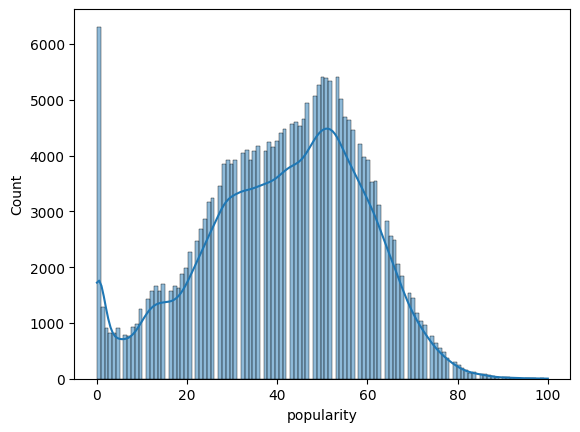

35.019% of the songs are above 50 in popularity
with an average popularity of 41.128


In [7]:
# how many songs are above 50 in popularity
hits = data[data['popularity'] > 50].shape[0]
miss = data[data['popularity'] < 50].shape[0]

# visulize the distribution of popularity
sns.histplot(data['popularity'], kde=True)
plt.show()

hits_ratio = hits/(hits+miss)*100
print(f"{hits_ratio:.3f}% of the songs are above 50 in popularity")
print(f"with an average popularity of {data['popularity'].mean():.3f}")

### Conclusions
- data has songs that are to long we want 8.3 minutes to be max and 1 minute to be min because we want to measure normal songs
- some attributes need to be transformed to numerical scale
- A capella is to small to be considered
- Children's Music and Children’s Music should be the same

### Data prepping steps
- remove song that are to long in duration songs longer than 500000 ms (500 seconds = 8.3 minutes)
- remove songs that are to short in duration songs shorter than 60000 ms (60 seconds = 1 minute)
- Remove A Capella songs due to being to small
- Combine union child genres into one genre Children's Music
- Split songs into it's genres
- Convert songs to flop or Bop based on popularity

### Create new attribute
- Genre count for each song with multilabeld genres

In [8]:
# Drop songs that are to long
data = data[data['duration_ms'] < 500000]
# Drop songs that are to short 
data = data[data['duration_ms'] > 60000]

# drop gernre a capella
data = data[data['genre'] != 'A Capella']

# Combine union child genres
data['genre'] = data['genre'].replace('Children’s Music', 'Children\'s Music')

# Create a new column for genre count
data['genre_count'] = data.groupby('track_id')['genre'].transform('count')

### Data Preprocessing
- Pitch preprocessing
- Time signature preprocessing
- Mode preprocessing (minor/major)
- Create datasets for each genre
- Flop or Bop labeling

In [9]:
# Function to convert pitch to number
def pitch_to_number(pitch):
    pitch_map = {
        'C': 0,
        'C#': 1, 'Db': 1,
        'D': 2,
        'D#': 3, 'Eb': 3,
        'E': 4, 'Fb': 4,
        'E#': 5, 'F': 5,
        'F#': 6, 'Gb': 6,
        'G': 7,
        'G#': 8, 'Ab': 8,
        'A': 9,
        'A#': 10, 'Bb': 10,
        'B': 11, 'Cb': 11
    }
    return pitch_map.get(pitch, None)

# Replace the pitch column with its numeric representation
# Assuming the column name in your DataFrame that contains pitch values is 'pitch_column'
data['key'] = data['key'].apply(pitch_to_number)

In [12]:
data['time_signature'] = (data['time_signature'].apply(lambda x: x.split('/')[0])).astype(int)

In [13]:
# Convert the mode column to 1 for major and 0 for minor
data['mode'] = data['mode'].replace("Minor", 0)
data['mode'] = data['mode'].replace("Major", 1)

In [14]:
# Group by genre and calculate mean popularity
grouped = data.groupby('genre')
mean_popularity = grouped['popularity'].mean()
mean_popularity = mean_popularity.sort_values(ascending=False)

In [15]:
# Function to label rows as 'bop' or 'flop'
def label_popularity(row, mean_popularity):
    if row['popularity'] >= mean_popularity[row['genre']]:
        return 'bop'
    else:
        return 'flop'

# Apply the function to each row
data['popularity_label'] = data.apply(lambda row: label_popularity(row, mean_popularity), axis=1)

# Splitting the data into bop and flop, ensuring each genre is split 50/50
# This step might require adjusting the labels for genres with an odd number of entries
for genre in data['genre'].unique():
    genre_data = data[data['genre'] == genre]
    n = len(genre_data) // 2
    popular_indices = genre_data.nlargest(n, 'popularity').index
    nonpopular_indices = genre_data.nsmallest(n, 'popularity').index
    data.loc[popular_indices, 'popularity_label'] = 'bop'
    data.loc[nonpopular_indices, 'popularity_label'] = 'flop'

### Visualization so far
- Visualize the distribution of the target variable in terms of genres
- Visualize the distribution of bop and flop songs in terms of genres songs from spotify with a popularity over 50 and under 50
- Visualize the distribution of the new 50/50 split to balance the dataset

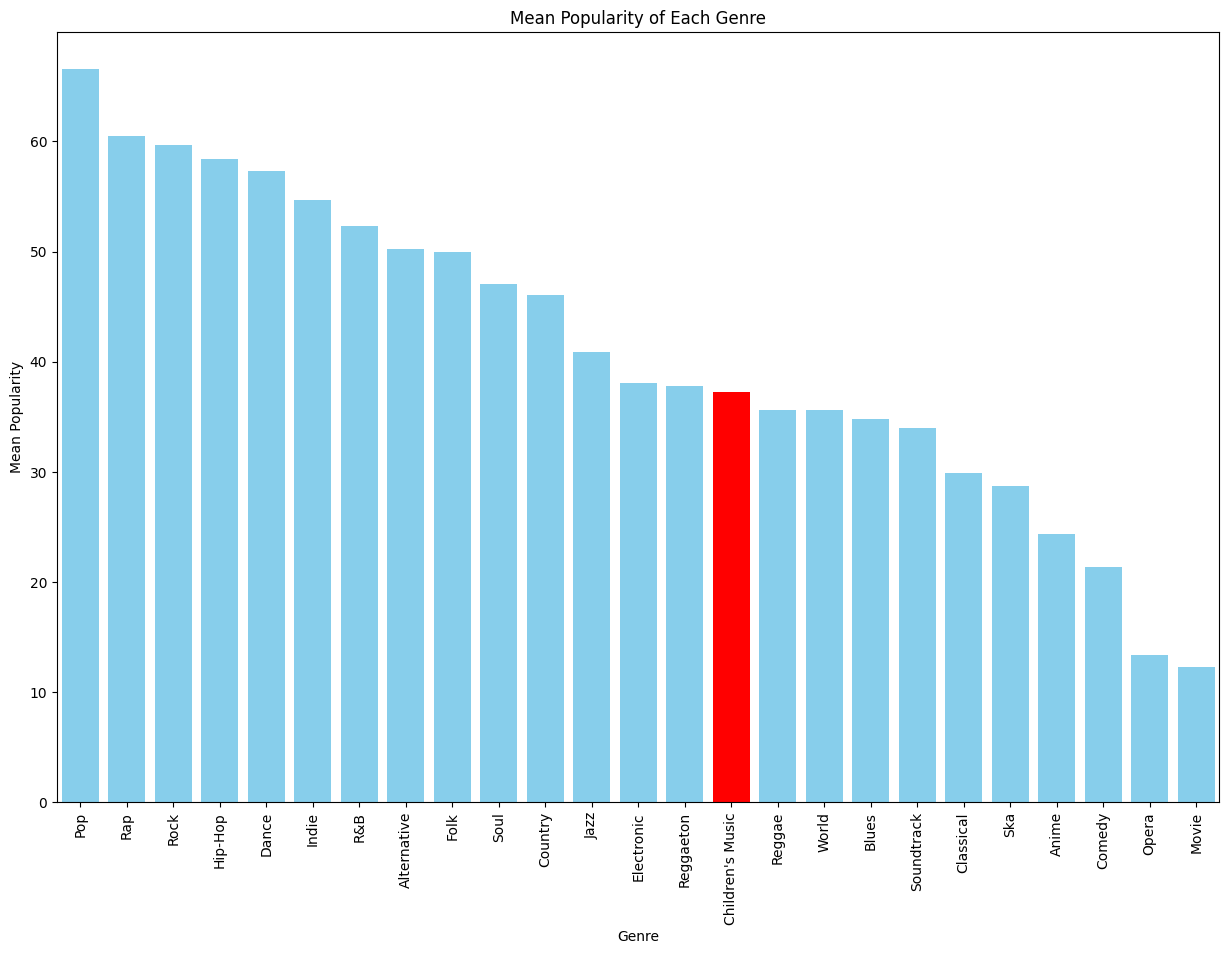

In [16]:
# plot the popularity of each genre and color children's music
mean_popularity.plot(kind='bar', figsize=(15, 10))
colors = ['red' if genre == 'Children\'s Music' else 'skyblue' for genre in mean_popularity.index]
plt.bar(mean_popularity.index, mean_popularity, color=colors)
plt.title('Mean Popularity of Each Genre')
plt.xlabel('Genre')
plt.ylabel('Mean Popularity')
plt.show()

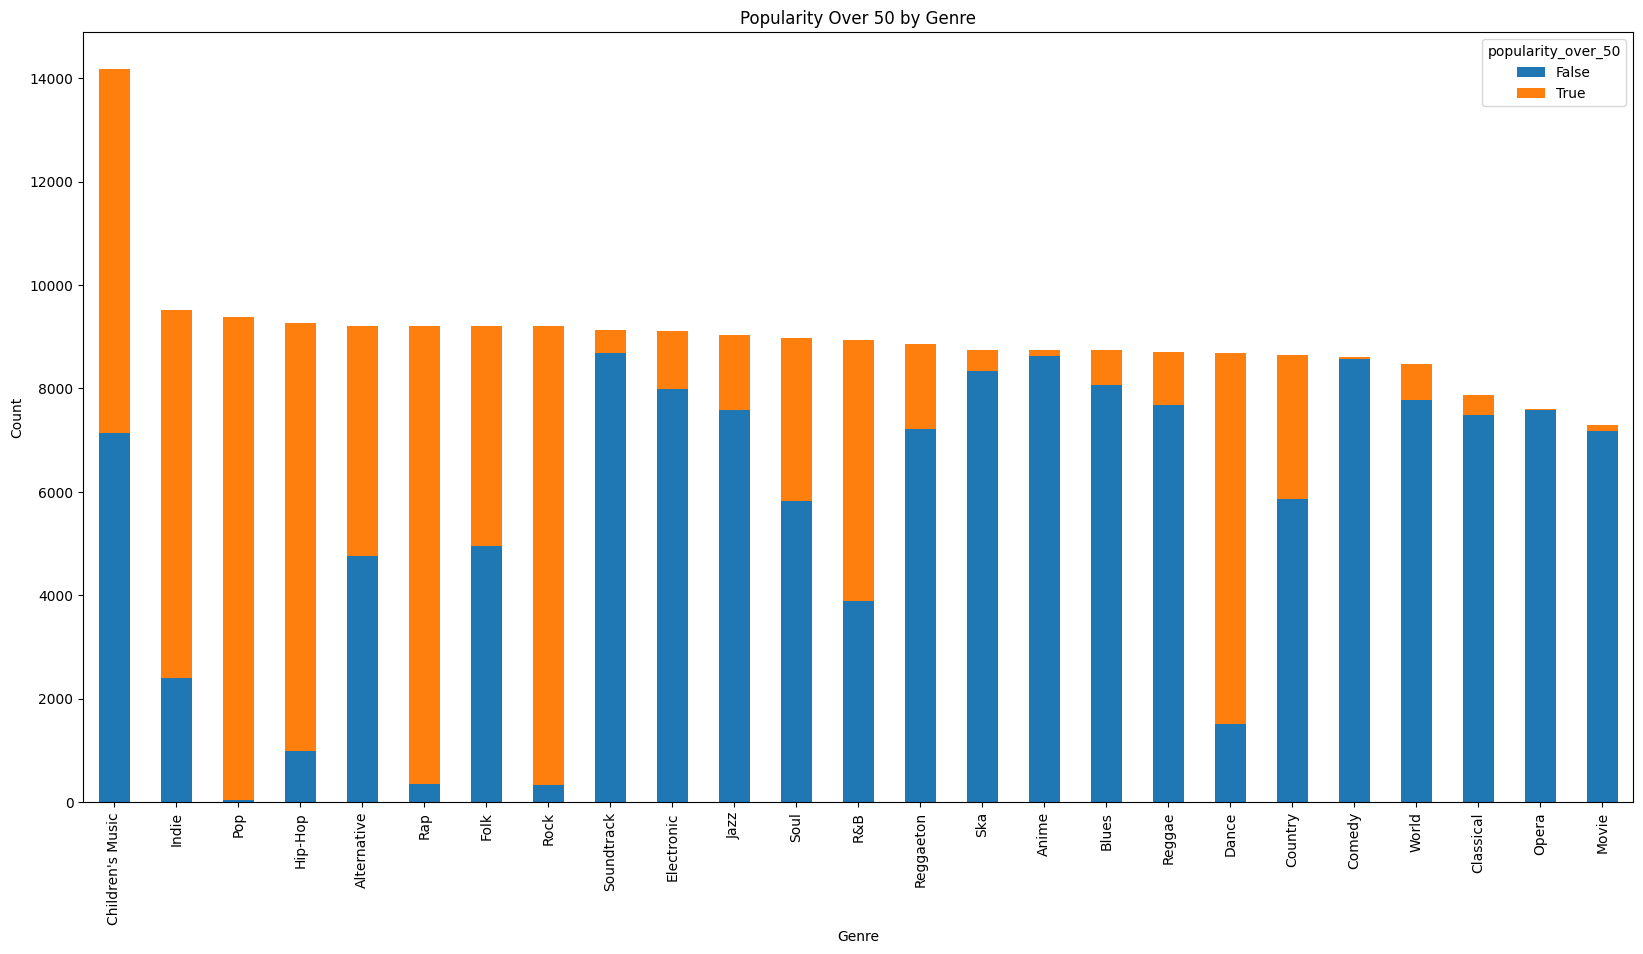

In [17]:
data['popularity_over_50'] = data['popularity'] >= 50

popularity_over_50_df = data.groupby(['genre', 'popularity_over_50']).size().unstack(fill_value=0)
popularity_over_50_df['total'] = popularity_over_50_df.sum(axis=1)
popularity_over_50_df_sorted = popularity_over_50_df.sort_values(by='total', ascending=False)
popularity_over_50_df_sorted = popularity_over_50_df_sorted.drop(columns='total')

# Plotting
popularity_over_50_df_sorted.plot(kind='bar', stacked=True, figsize=(20, 10))
plt.title('Popularity Over 50 by Genre')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.show()


In [18]:
accuracy_dict_over50 = {}
for genre in data['genre'].unique():
    genre_data = data[data['genre'] == genre]
    genre_data = genre_data.dropna()
    X = genre_data[['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']]
    y = genre_data['popularity_over_50']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    accuracy_dict_over50[genre] = accuracy
    print(f'Accuracy for {genre}: {accuracy}')


Accuracy for Movie: 0.9869952087611226
Accuracy for R&B: 0.5626398210290827
Accuracy for Alternative: 0.5347448425624322
Accuracy for Country: 0.6589595375722543
Accuracy for Dance: 0.8227848101265823
Accuracy for Electronic: 0.875
Accuracy for Anime: 0.9817142857142858
Accuracy for Folk: 0.5331161780673181
Accuracy for Blues: 0.9165714285714286
Accuracy for Opera: 0.997370151216305
Accuracy for Hip-Hop: 0.8963842417701026
Accuracy for Children's Music: 0.764456981664316
Accuracy for Rap: 0.9647122692725298
Accuracy for Indie: 0.7468487394957983
Accuracy for Classical: 0.9466666666666667
Accuracy for Pop: 0.9957333333333334
Accuracy for Reggae: 0.8770114942528736
Accuracy for Reggaeton: 0.8005649717514124
Accuracy for Jazz: 0.8373893805309734
Accuracy for Rock: 0.9630434782608696
Accuracy for Ska: 0.9537407195888064
Accuracy for Comedy: 0.9970947123765252
Accuracy for Soul: 0.6310517529215359
Accuracy for Soundtrack: 0.9496442255062945
Accuracy for World: 0.9162735849056604


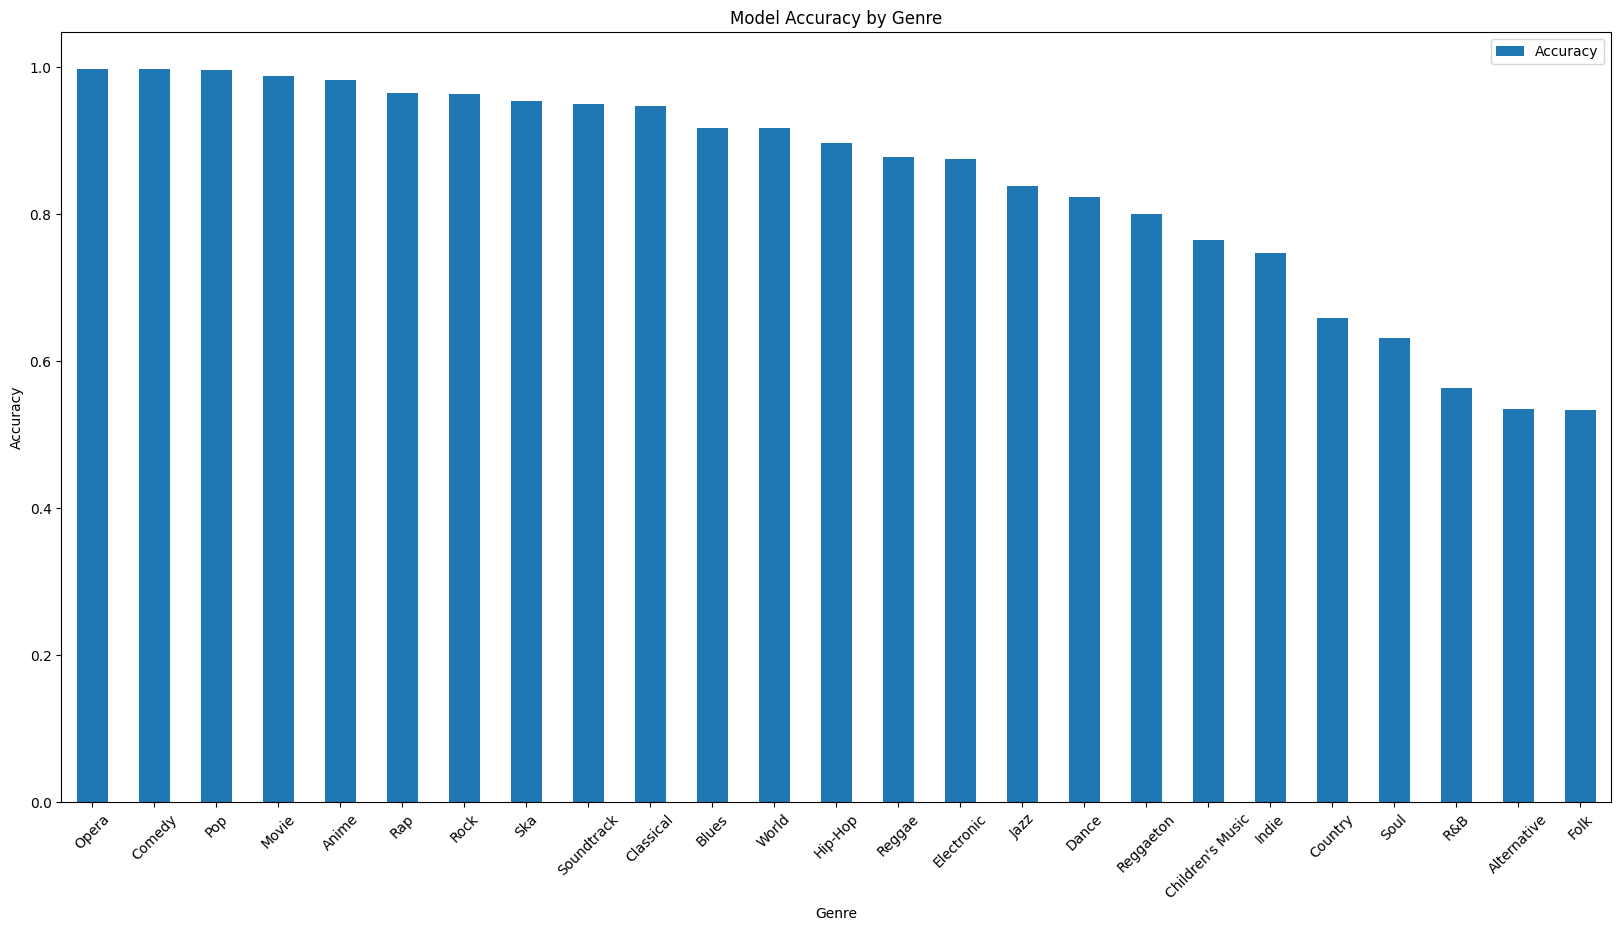

In [19]:
accuracy_dict_over50 = dict(sorted(accuracy_dict_over50.items(), key=lambda item: item[1], reverse=True))

accuracy_df = pd.DataFrame(list(accuracy_dict_over50.items()), columns=['Genre', 'Accuracy'])

accuracy_df.plot(kind='bar', x='Genre', y='Accuracy', figsize=(20, 10), legend=True)
plt.title('Model Accuracy by Genre')
plt.ylabel('Accuracy')
plt.xlabel('Genre')
plt.xticks(rotation=45)
plt.show()

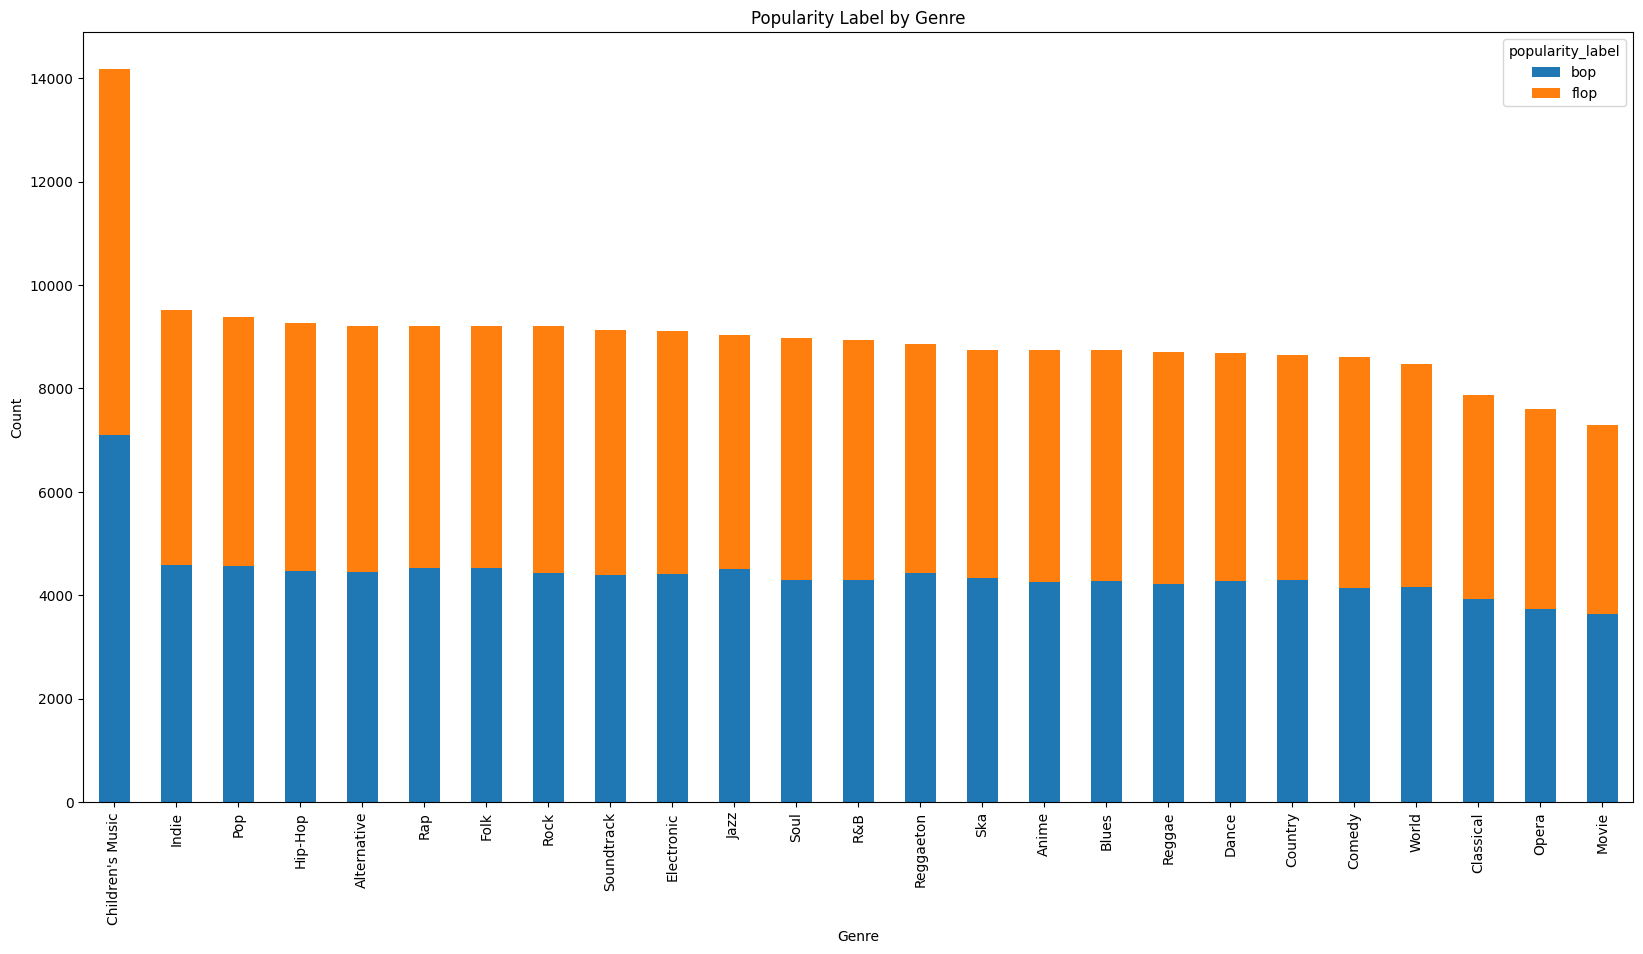

In [20]:

popularity_label_df = data.groupby(['genre', 'popularity_label']).size().unstack(fill_value=0)


popularity_label_df['total'] = popularity_label_df.sum(axis=1)


popularity_label_df_sorted = popularity_label_df.sort_values(by='total', ascending=False)
popularity_label_df_sorted = popularity_label_df_sorted.drop(columns='total')

popularity_label_df_sorted.plot(kind='bar', stacked=True, figsize=(20, 10))
plt.title('Popularity Label by Genre')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.show()


In [21]:
accuracy_dict_50percent = {}
for genre in data['genre'].unique():
    genre_data = data[data['genre'] == genre]
    genre_data = genre_data.dropna()
    X = genre_data[['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']]
    y = genre_data['popularity_label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    accuracy_dict_50percent[genre] = accuracy
    print(f'Accuracy for {genre}: {accuracy}')

    


Accuracy for Movie: 0.6461327857631759
Accuracy for R&B: 0.5268456375838926
Accuracy for Alternative: 0.5331161780673181
Accuracy for Country: 0.5190751445086705
Accuracy for Dance: 0.5627157652474108
Accuracy for Electronic: 0.5487938596491229
Accuracy for Anime: 0.6017142857142858
Accuracy for Folk: 0.5168295331161781
Accuracy for Blues: 0.54
Accuracy for Opera: 0.5627876397107167
Accuracy for Hip-Hop: 0.5321100917431193
Accuracy for Children's Music: 0.7651622002820875
Accuracy for Rap: 0.5266015200868621
Accuracy for Indie: 0.5646008403361344
Accuracy for Classical: 0.6241269841269841
Accuracy for Pop: 0.5541333333333334
Accuracy for Reggae: 0.5224137931034483
Accuracy for Reggaeton: 0.5898305084745763
Accuracy for Jazz: 0.5851769911504425
Accuracy for Rock: 0.5266304347826087
Accuracy for Ska: 0.5511136493432325
Accuracy for Comedy: 0.6583381754793725
Accuracy for Soul: 0.5559265442404007
Accuracy for Soundtrack: 0.5123152709359606
Accuracy for World: 0.5501179245283019


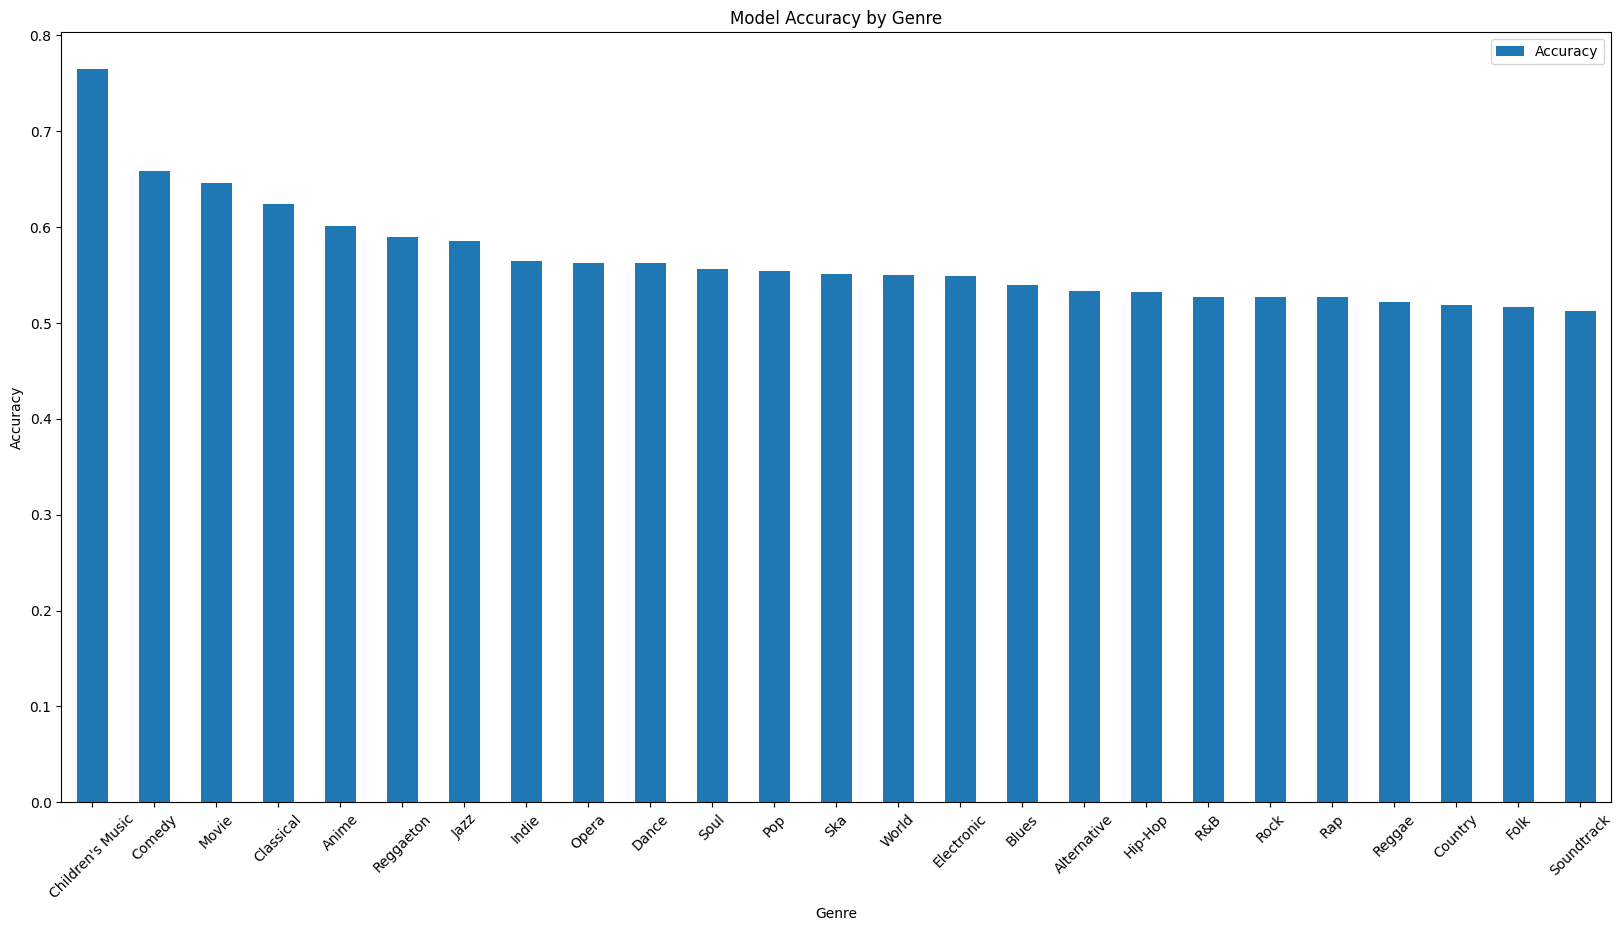

In [22]:
accuracy_dict_50percent = dict(sorted(accuracy_dict_50percent.items(), key=lambda item: item[1], reverse=True))

accuracy_df = pd.DataFrame(list(accuracy_dict_50percent.items()), columns=['Genre', 'Accuracy'])

# Plotting
accuracy_df.plot(kind='bar', x='Genre', y='Accuracy', figsize=(20, 10), legend=True)
plt.title('Model Accuracy by Genre')
plt.ylabel('Accuracy')
plt.xlabel('Genre')
plt.xticks(rotation=45)
plt.show()

### Comments on genre selection to further analyze
- By splitting the genres into it's own column we can now analyze the data in terms of genres this results in us having 25 datasets to analyze. To make the analysis easier to understand we will only analyze the biggest dataset children's music. 

### Next steps
- quick overview
  - check for duplicates
  - check avg popularity (to understand target variable)
  - find weird values
  - Analyze artist distribution (to understand if the artst with the most songs can make the dataset biased) # side note: Each artist has a different style so this could be a good thing
- Analyze 

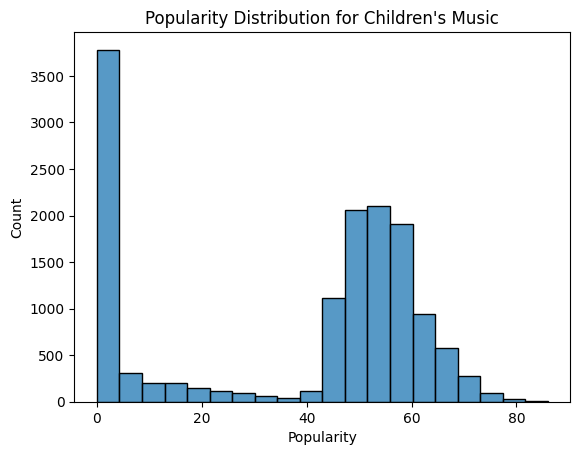

37.217489421720735


In [23]:
childrens_music = data[data['genre'] == 'Children\'s Music']
# plot the distribution of popularity for children's music
sns.histplot(childrens_music['popularity'])
plt.title('Popularity Distribution for Children\'s Music')
plt.xlabel('Popularity')
plt.ylabel('Count')
plt.show()
print(childrens_music['popularity'].mean())

In [24]:
# Check for songs with same track_id to find duplicates
print(childrens_music[childrens_music['track_id'].duplicated()])

Empty DataFrame
Columns: [genre, artist_name, track_name, track_id, popularity, acousticness, danceability, duration_ms, energy, instrumentalness, key, liveness, loudness, mode, speechiness, tempo, time_signature, valence, genre_count, popularity_label, popularity_over_50]
Index: []

[0 rows x 21 columns]


In [25]:
# Find songs with bad values - like the sample below
childrens_music[childrens_music['track_id'] == '7ARLbcqLgOrBI2JfzfKtHD']

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,...,liveness,loudness,mode,speechiness,tempo,time_signature,valence,genre_count,popularity_label,popularity_over_50
97932,Children's Music,New Medicine,Rich Kids - [Middle Cla$$ MIX],7ARLbcqLgOrBI2JfzfKtHD,51,0.0183,0.619,181907,0.936,0.0,...,0.361,-2.205,0,0.0739,108.011,4,0.739,2,bop,True


In [26]:
# Replace the $ in the track_name and artist_name columns with s
childrens_music.loc[:, 'track_name'] = childrens_music['track_name'].str.replace('$', 's')
childrens_music.loc[:, 'artist_name'] = childrens_music['artist_name'].str.replace('$', 's')

childrens_music[childrens_music['track_id'] == '7ARLbcqLgOrBI2JfzfKtHD']

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,...,liveness,loudness,mode,speechiness,tempo,time_signature,valence,genre_count,popularity_label,popularity_over_50
97932,Children's Music,New Medicine,Rich Kids - [Middle Class MIX],7ARLbcqLgOrBI2JfzfKtHD,51,0.0183,0.619,181907,0.936,0.0,...,0.361,-2.205,0,0.0739,108.011,4,0.739,2,bop,True


In [27]:
total_songs = len(childrens_music)
 
# Calculate the average popularity for each artist
avg_popularity_by_artist = childrens_music.groupby('artist_name')['popularity'].mean()

# Find the top 20 artists by the number of songs
top_20_artists = childrens_music['artist_name'].value_counts().head(20)
top_20_artists_df = top_20_artists.reset_index()
top_20_artists_df.columns = ['artist_name', 'Song Count']

# Merge the average popularity data with the top 20 artists DataFrame
top_20_artists_with_avg_popularity = pd.merge(top_20_artists_df, avg_popularity_by_artist, on='artist_name')

# Calculate the share of total songs for each of the top 20 artists and add it to the DataFrame
top_20_artists_with_avg_popularity['% of songs'] = (top_20_artists_with_avg_popularity['Song Count'] / total_songs) * 100

#'Share of Total Songs (%)' round 2 decimals
top_20_artists_with_avg_popularity['popularity'] = top_20_artists_with_avg_popularity['popularity'].round(2)
top_20_artists_with_avg_popularity['% of songs'] = top_20_artists_with_avg_popularity['% of songs'].round(2)

print(top_20_artists_with_avg_popularity)

                            artist_name  Song Count  popularity  % of songs
0                Kimbo Children's Music         885        0.79        6.24
1                           Juice Music         616        4.60        4.34
2                Children Songs Company         366        0.04        2.58
3                    The Countdown Kids         262        1.54        1.85
4         Music For Little People Choir         177        3.60        1.25
5                     The Hit Crew Kids         162        1.43        1.14
6                      Sugar Kane Music         127        4.68        0.90
7                      Mogul Music Inc.         118        5.64        0.83
8                         The Wayfarers          97        0.00        0.68
9                           Enzo Garcia          91        0.24        0.64
10        Nursery Rhymes and Kids Songs          87        1.14        0.61
11              Five Finger Death Punch          78       53.53        0.55
12          

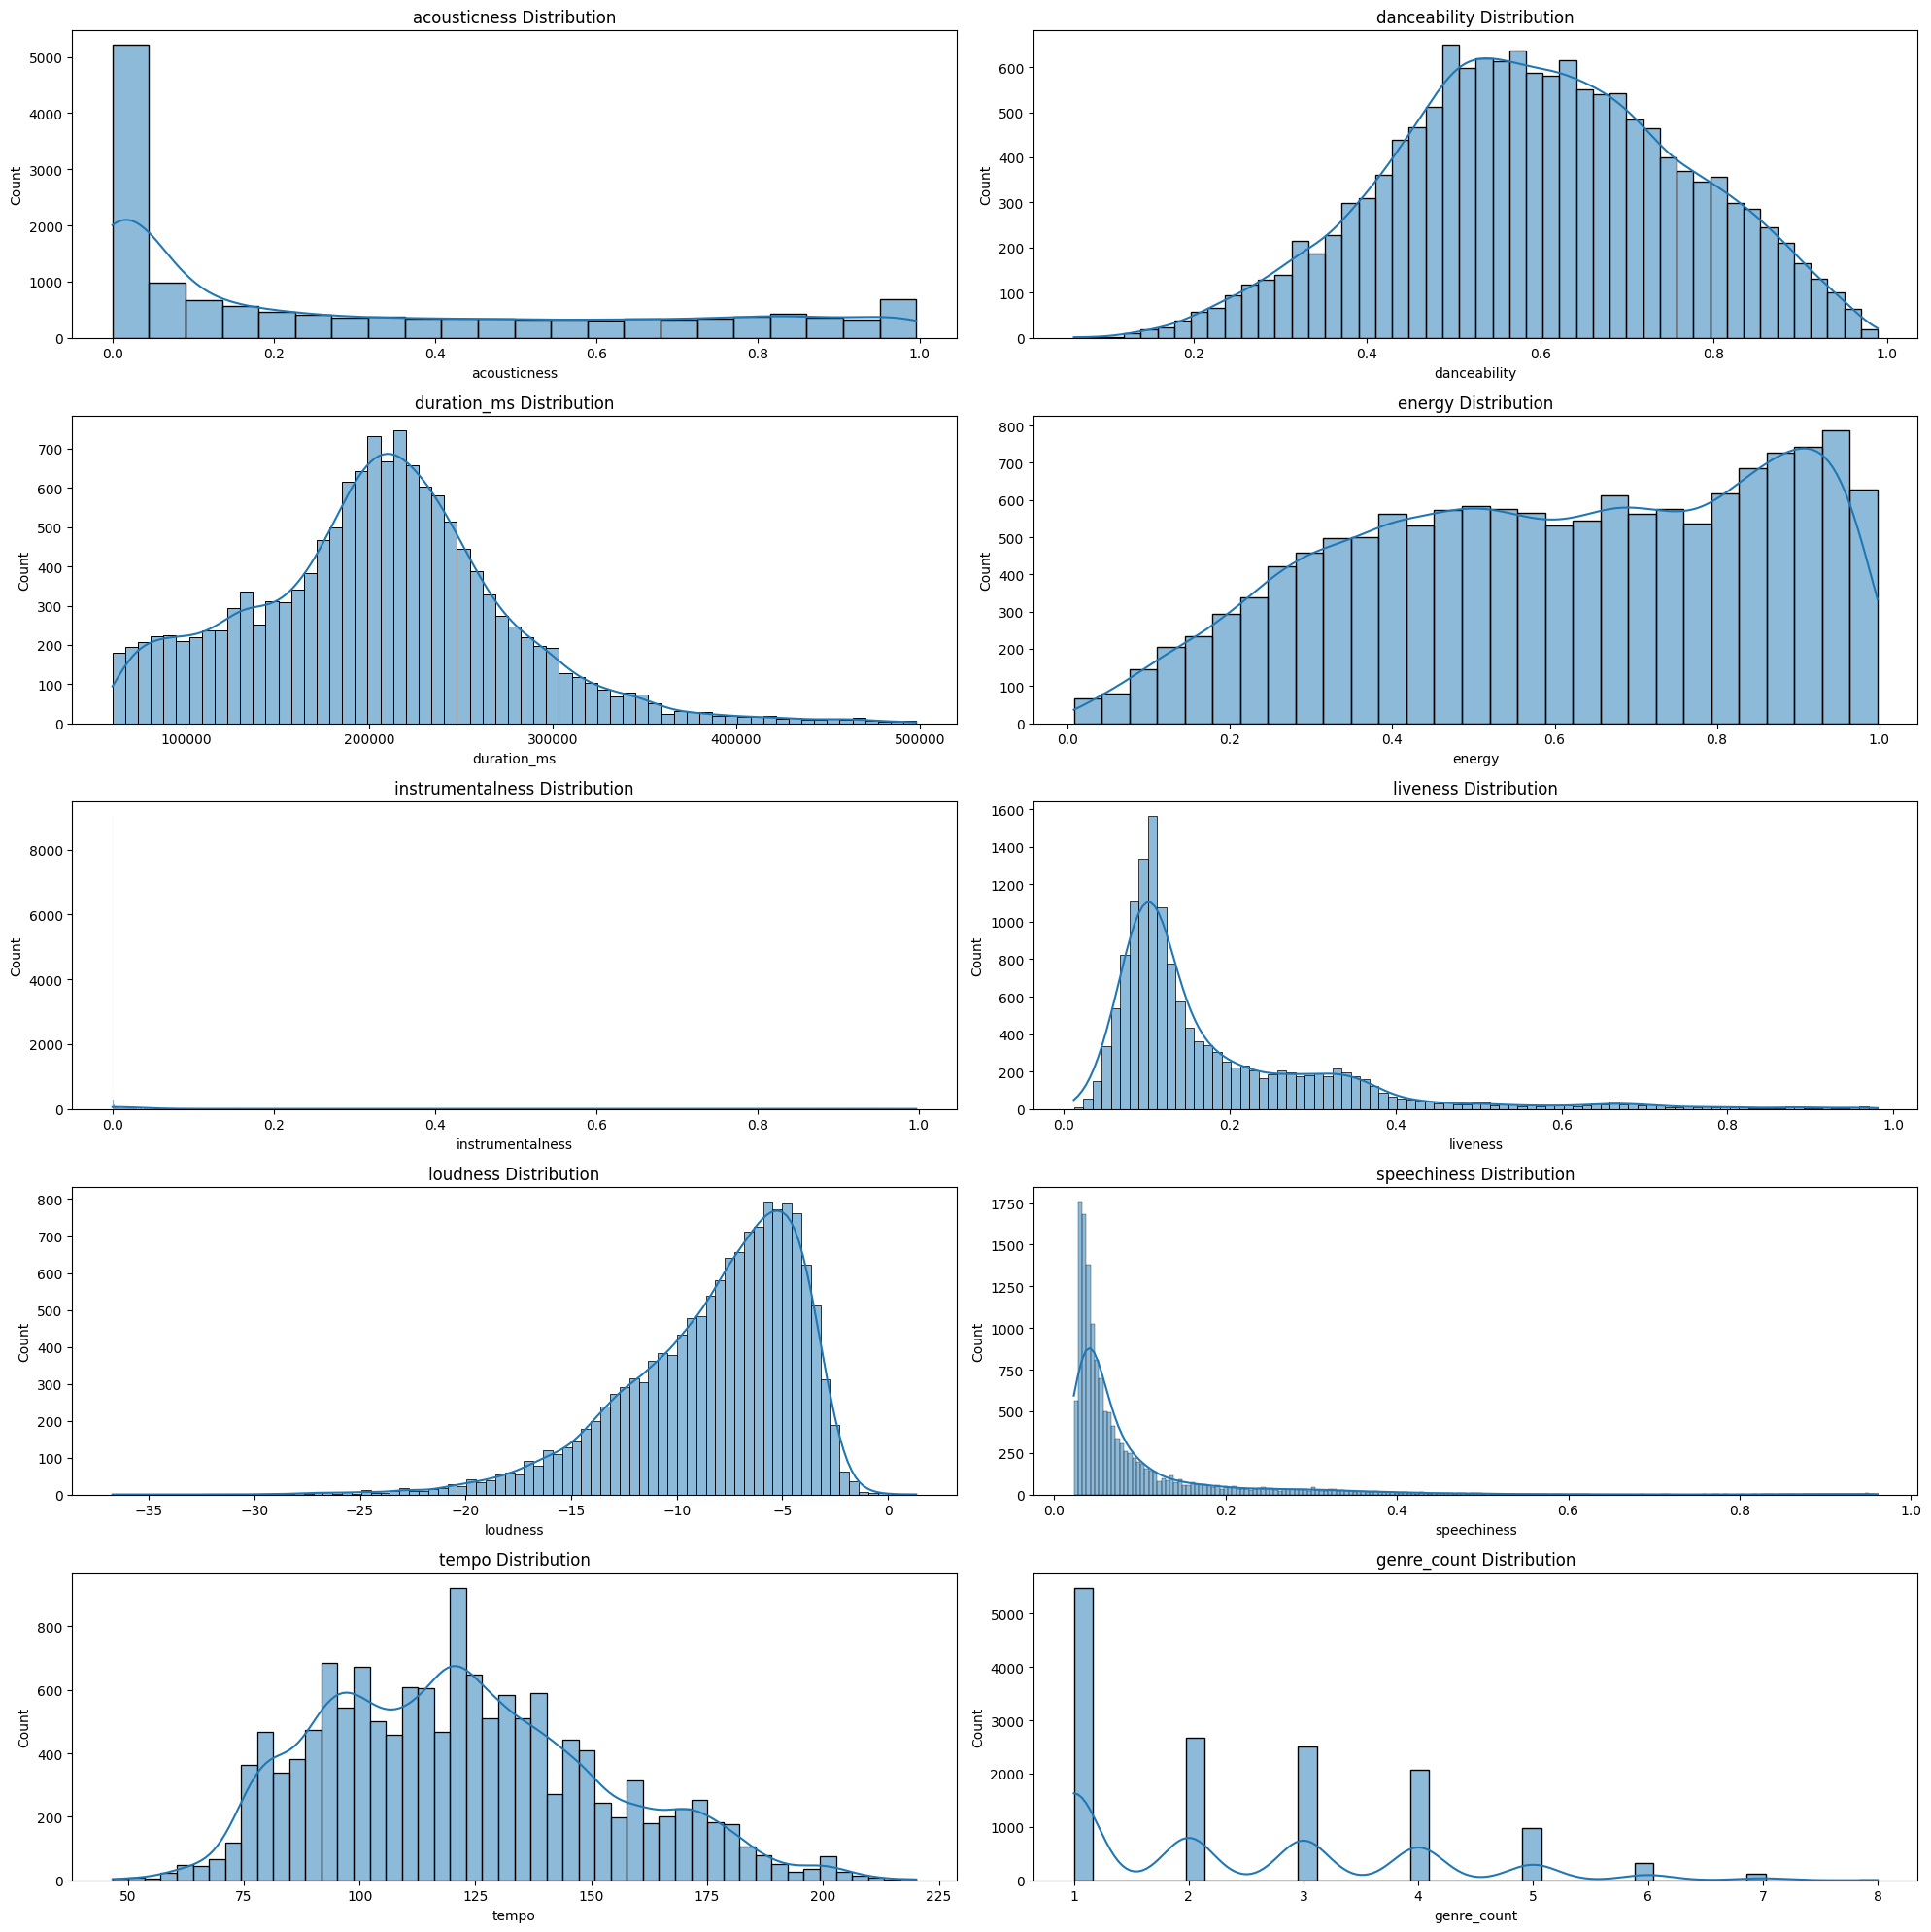

In [28]:
# Create a list of the columns to plot with audio features, duration and genre count
columns = ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'genre_count']

# Create a figure and axis to plot on
fig, ax = plt.subplots(5, 2, figsize=(20, 20))

# Flatten the axis to make it easier to iterate over
ax = ax.flatten()

# Iterate over the columns and plot each one
for i, col in enumerate(columns):
    sns.histplot(childrens_music[col], kde=True, ax=ax[i])
    ax[i].set_title(f'{col} Distribution')

# Display the plots
plt.tight_layout()
plt.show()


In [29]:
# Dive deeper into instrumentalness
instrumentalness = childrens_music['instrumentalness']
instrumentalness.describe()

# show the most common values for instrumentalness and how many songs are above 0
instrumentalness.value_counts().head(10), childrens_music.shape[0]

(instrumentalness
 0.000000    4856
 0.000123      13
 0.000106      12
 0.000001      12
 0.000011      12
 0.000011      11
 0.001030      11
 0.000001      11
 0.862000      10
 0.160000      10
 Name: count, dtype: int64,
 14180)

### Test a model to see 
- feature importance
- current preformance

In [30]:
# Run a test to see what feature is the most important
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Create a new DataFrame with only the audio features and the popularity label
X = childrens_music[['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo']]
y = childrens_music['popularity_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_0 = RandomForestClassifier(n_estimators=100, random_state=42)
model_0.fit(X_train, y_train)
y_pred = model_0.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         bop       0.71      0.84      0.77      1406
        flop       0.81      0.65      0.72      1430

    accuracy                           0.75      2836
   macro avg       0.76      0.75      0.75      2836
weighted avg       0.76      0.75      0.75      2836



In [31]:
feature_importances = pd.DataFrame(model_0.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
print("feature importances")
print(feature_importances)

feature importances
                  importance
loudness            0.175411
acousticness        0.172624
danceability        0.138263
energy              0.136684
tempo               0.101936
speechiness         0.097058
liveness            0.091097
instrumentalness    0.086927


###  Conclusion on Children's Music dataset
- The 2 biggest artists are contributing to 10% of the dataset which is not to much to make the dataset biased 
- The dataset need some some scaling and normalization to be able to use it in a model
- the target variable is now flop or bop and popularity is not needed anymore
- The most import features can be viewed above.
- The dataset is now free from weird values and duplicates

### Next steps
- preform log transformation on the dataset to make it a tiny bit more normal distributed
- split the dataset into a train and test set before scaling to prevent data leakage
- scale the dataset before preforming PCA
- preform PCA to reduce the dimensionality of the dataset

/tmp/ipykernel_48355/465052090.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  childrens_music['liveness'] = np.log1p(childrens_music['liveness'])
/tmp/ipykernel_48355/465052090.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  childrens_music['speechiness'] = np.log1p(childrens_music['speechiness'])


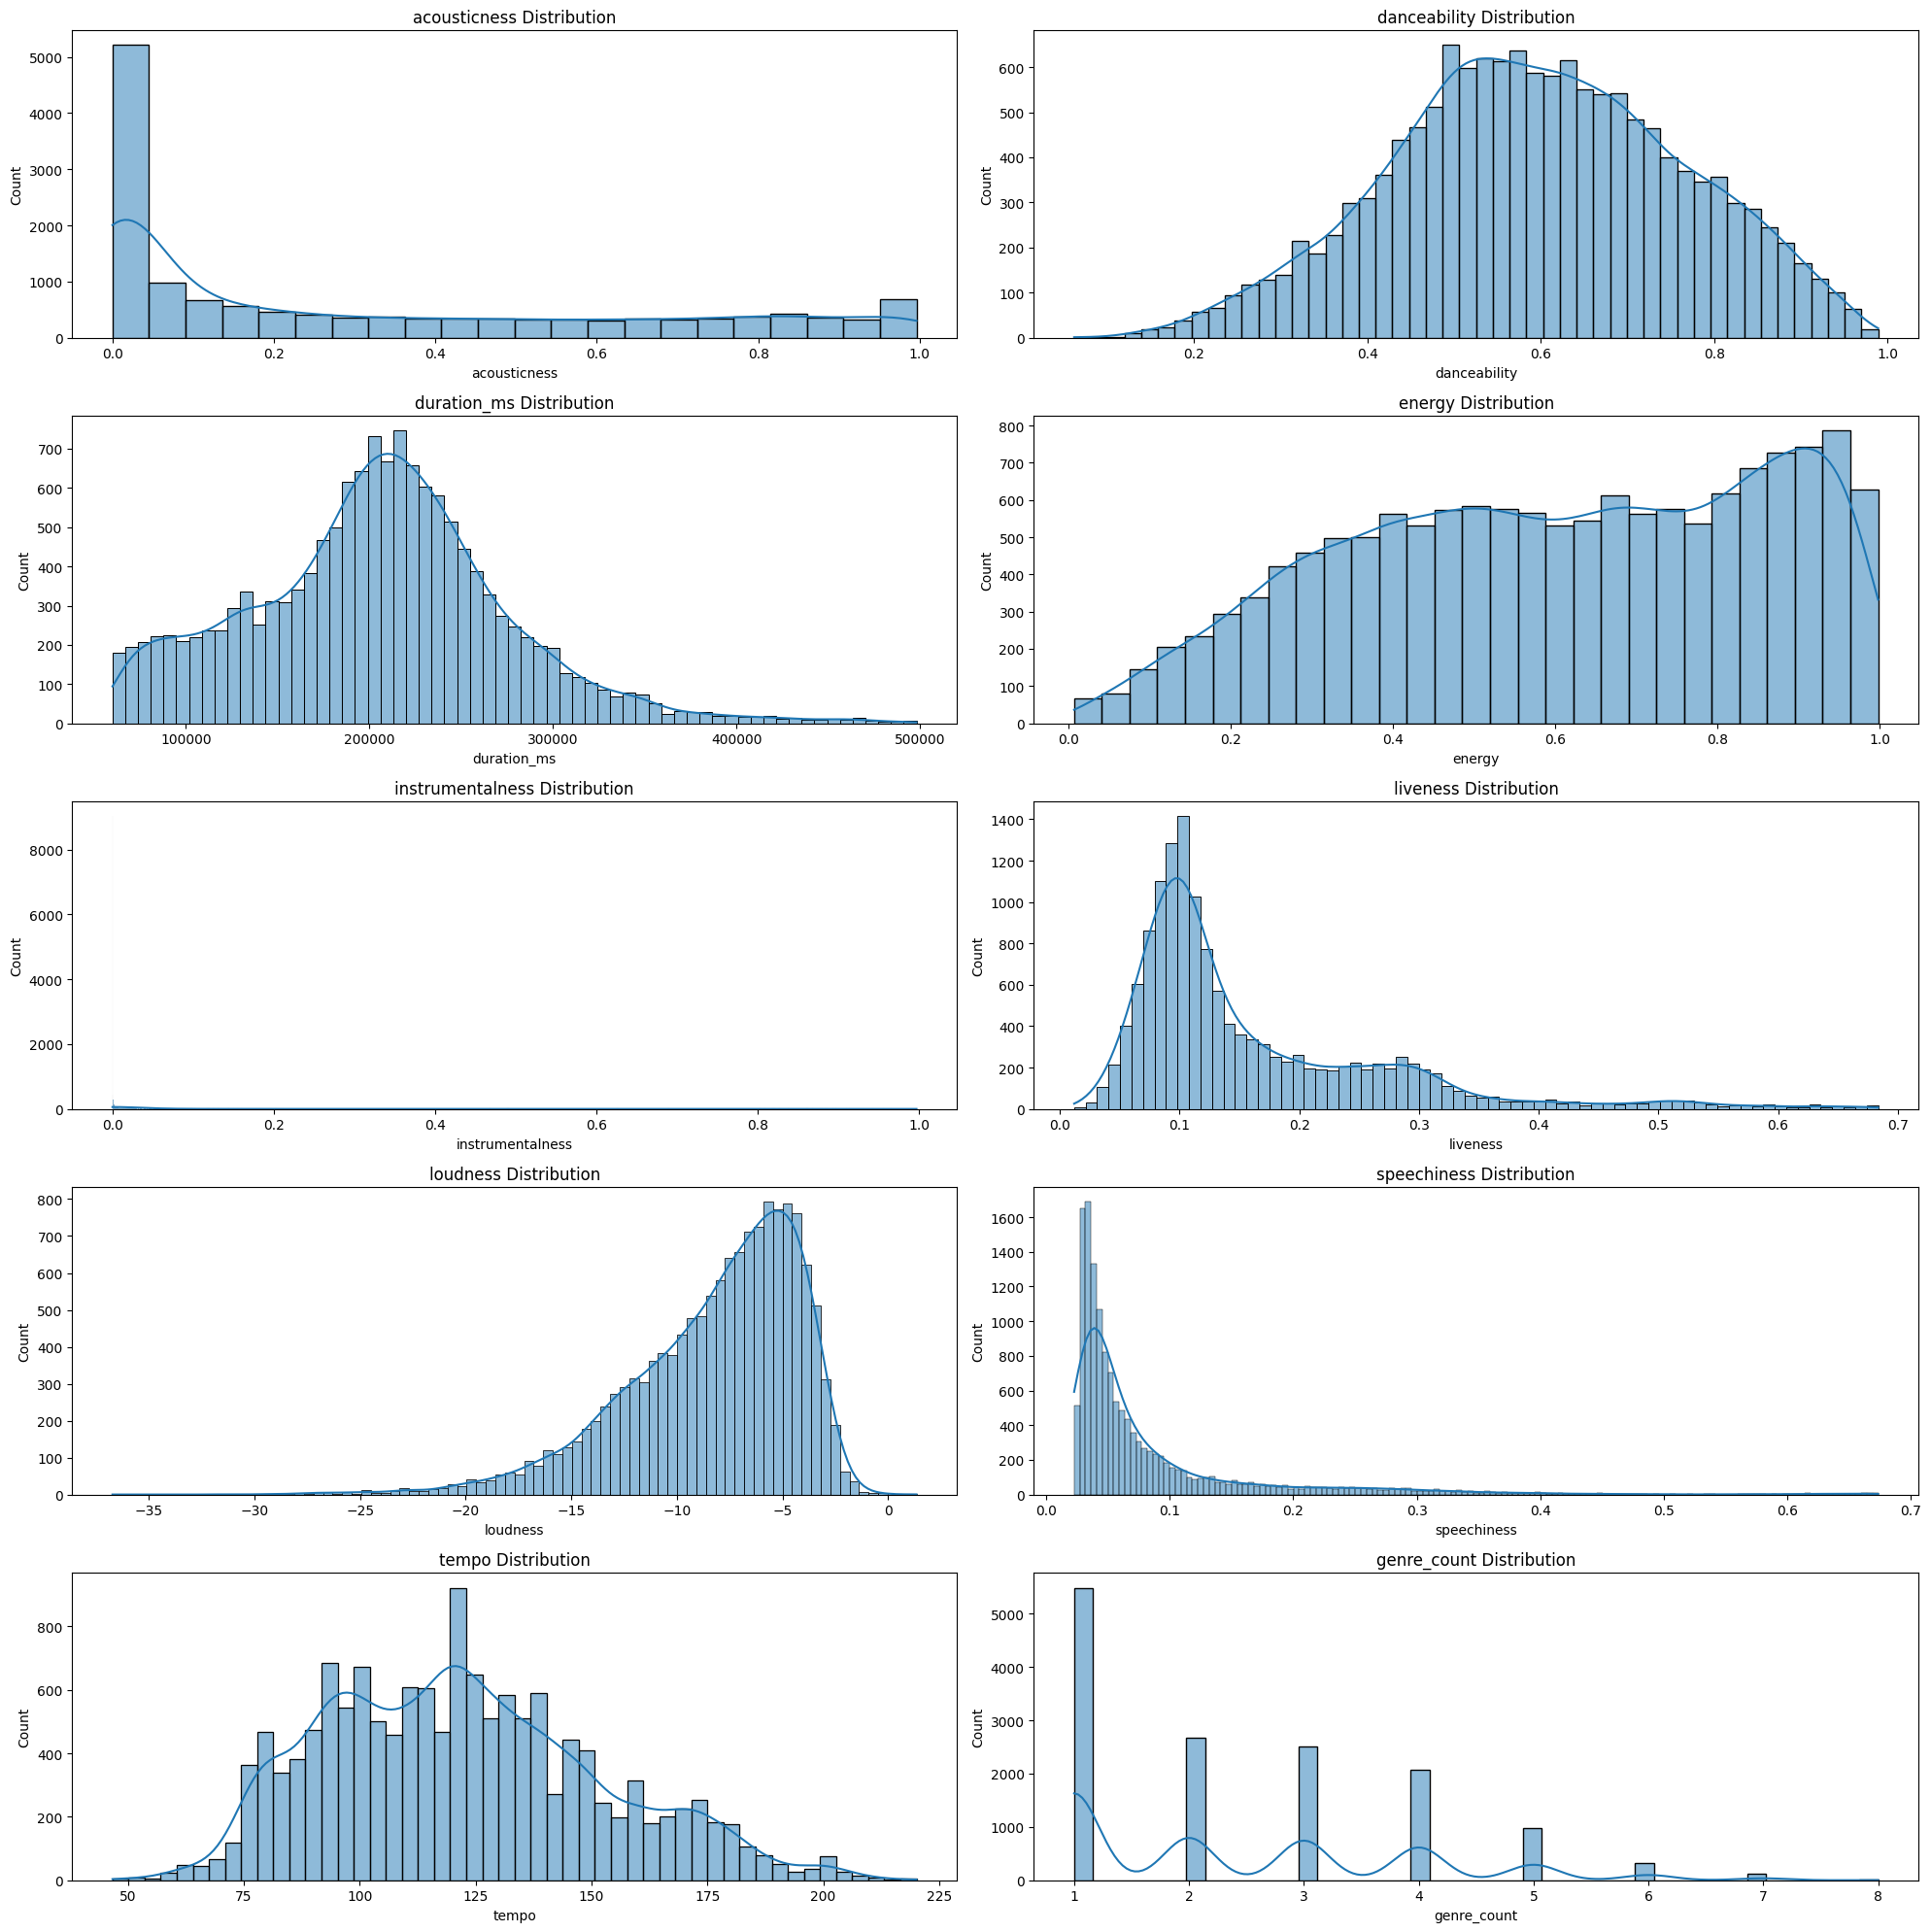

In [32]:
# preform logtransofrmation on livness, speechiness
childrens_music['liveness'] = np.log1p(childrens_music['liveness'])
childrens_music['speechiness'] = np.log1p(childrens_music['speechiness'])

# Create a figure and axis to plot on
fig, ax = plt.subplots(5, 2, figsize=(20, 20))

# Flatten the axis to make it easier to iterate over
ax = ax.flatten()

# Iterate over the columns and plot each one
for i, col in enumerate(columns):
    sns.histplot(childrens_music[col], kde=True, ax=ax[i])
    ax[i].set_title(f'{col} Distribution')

# Display the plots
plt.tight_layout()
plt.show()

# get data to csv
childrens_music.to_csv('childrens_music.csv', index=False)

In [33]:
# What data do we want and what order do we want it
X = childrens_music[['track_name', 'artist_name', 'track_id', 'genre_count','mode', 'time_signature','acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'duration_ms', 'valence']]
y = childrens_music['popularity_label']

# Split the data into a training and testing set for final model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.head()

,track_name,artist_name,track_id,genre_count,mode,time_signature,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,duration_ms,valence
73699,Adome (Ghana),Kimbo Children's Music,1M15KNP9SrC0V8Hp72unfD,1,0,4,0.55000,0.648,0.343,0.000013,0.083238,-16.401,0.309688,138.804,125200,0.194
99620,Better Days,The Goo Goo Dolls,2CWYATyxjd8tOsXdyuRWUv,3,1,4,0.00174,0.486,0.592,0.001140,0.089384,-5.176,0.029365,113.228,213267,0.329
71740,Three Little Ducks,Old Town School of Folk Music,063ugdBIIFpstBUxJclVv1,1,1,4,0.58100,0.693,0.334,0.000198,0.095310,-8.455,0.046502,145.504,74733,0.520
103452,Halaga,Parokya Ni Edgar,6pz4tdLoIDJdnpXnisSDCK,1,1,4,0.13200,0.489,0.570,0.000001,0.242162,-9.197,0.035753,134.486,352120,0.643
73038,Itsy Bitsy Spider,Music For Little People Choir,3cc6oBhhq7AwhdHuPsCvJn,1,1,4,0.69300,0.797,0.117,0.000000,0.308220,-18.264,0.069060,98.930,152200,0.282


In [34]:
predict_features = ['genre_count', 'mode', 'time_signature','acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']

model_2 = RandomForestClassifier(n_estimators=100, random_state=42)

model_2.fit(X_train[predict_features], y_train)

y_pred = model_2.predict(X_test[predict_features])

print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

         bop       0.81      0.92      0.86      1406
        flop       0.91      0.79      0.84      1430

    accuracy                           0.85      2836
   macro avg       0.86      0.85      0.85      2836
weighted avg       0.86      0.85      0.85      2836



#### Scaling selection
Standard scaler: This technique transforms the features so they have the properties of a standard normal distribution with a mean of 0 and a standard deviation of 1. It's useful when your data follows a Gaussian distribution and when using algorithms sensitive to variance in the data, such as Support Vector Machines (SVMs) and Principal Component Analysis (PCA). From this we will exclude genre count.

In [35]:
from sklearn.preprocessing import StandardScaler

# Selecting the numerical features for standardization
numerical_features = ['acousticness', 'danceability', 'duration_ms', 'energy', 
                      'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']

# Standardizing the numerical features
scaler = StandardScaler()

# Fit and transform the training data
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])

# Transform the testing data
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

X_test.head()

,track_name,artist_name,track_id,genre_count,mode,time_signature,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,duration_ms,valence
77903,Daughter (Remastered),Pearl Jam,53eJFr4Mfbw5PXJ01K6cFw,4,1,4,-0.895943,0.119551,0.398200,-0.354155,-0.922453,-0.342482,-0.644101,-0.823430,0.426398,0.828177
79106,Call It What You Want,Foster The People,3u1Er1rkjn1oSz1xdZH3ZD,4,0,4,-0.773292,0.275321,1.451802,-0.371993,1.821584,0.960524,-0.298402,-0.290540,0.490035,0.792077
74866,Ringa Ringa Little Finger,Radha,4muLYTF9CenwUG8KGpnefp,1,1,4,0.871565,0.850472,-1.796473,-0.373213,-0.193042,-1.289135,3.690678,0.436160,-1.728958,-1.638656
100418,Change On Me (feat. Leuca),Xavier Omär,2j7qlbFwdLSB1HP3GJNpNi,5,0,4,-0.137513,0.598843,-0.464561,-0.373213,-0.509185,-0.097429,0.454474,0.539266,0.299351,-0.704067
76694,Tenderly,Little Apple Band,1ET6rWY5H7QIymsqIkRVvF,1,1,4,-0.706621,1.114082,0.537355,-0.373145,-0.525289,0.394367,0.144807,-1.522067,-1.327371,1.129010


In [36]:
predict_features = ['genre_count', 'mode', 'time_signature','acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']

model_2 = RandomForestClassifier(n_estimators=100, random_state=42)

model_2.fit(X_train[predict_features], y_train)

y_pred = model_2.predict(X_test[predict_features])

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         bop       0.81      0.92      0.86      1406
        flop       0.91      0.78      0.84      1430

    accuracy                           0.85      2836
   macro avg       0.86      0.85      0.85      2836
weighted avg       0.86      0.85      0.85      2836



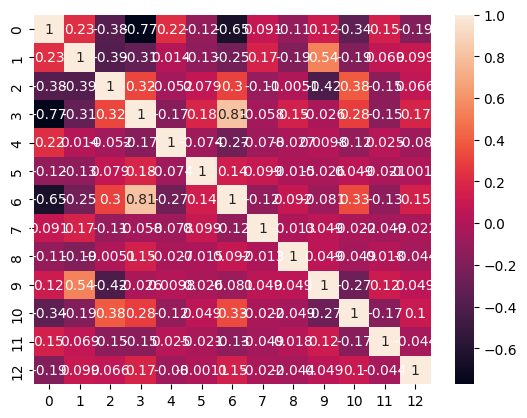

PCA is not recommended based on the correlation matrix. There are 5 pairs of highly correlated variables.


In [37]:
# Assuming X_train[features] is your scaled dataset for training
features = ['acousticness', 'danceability', 'duration_ms', 'energy', 
            'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'genre_count', 'mode', 'time_signature']

# Correlation analysis
corr_matrix = np.corrcoef(X_train[features].T)
sns.heatmap(corr_matrix, annot=True)
plt.show()

high_correlation_threshold = 0.6

# Calculate the number of variables with at least one high correlation
# We subtract the count by the length of the matrix to ignore the diagonal (self-correlation)
high_correlations = np.sum((np.abs(corr_matrix) > high_correlation_threshold) & (corr_matrix != 1)) / 2


# Decide whether PCA is recommended
# This threshold can be adjusted based on the size of the matrix or domain knowledge
pca_recommended = high_correlations > len(corr_matrix) * 0.5

print(f"PCA is {'recommended' if pca_recommended else 'not recommended'} based on the correlation matrix. There are {int(high_correlations)} pairs of highly correlated variables.")

### We decided to use PCA anyway
because we want to see the impact of the features on the target variable and we want to see if we can reduce the dimensionality of the dataset

In [ ]:
from sklearn.decomposition import PCA

# Choosing the number of components for PCA
n_components = 6

# Creating a PCA object with the chosen number of components
pca = PCA(n_components=n_components)

# Fitting the PCA on the scaled training data and transforming the training data
X_train_pca = pca.fit_transform(X_train)

# Transforming the scaled testing data using the fitted PCA
X_test_pca = pca.transform(X_test)

# If needed, creating a DataFrame for the PCA-transformed training data for easier analysis
pca_columns = [f'PC{i+1}' for i in range(n_components)]
pca_train_df = pd.DataFrame(X_train_pca, columns=pca_columns)

# Similarly, creating a DataFrame for the PCA-transformed testing data
pca_test_df = pd.DataFrame(X_test_pca, columns=pca_columns)

# Display the first few rows of the PCA-transformed training DataFrame
print(pca_train_df.head())

# Additionally, to examine the variance explained by the chosen components
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = explained_variance_ratio.cumsum()

print("Explained variance ratio by component:", explained_variance_ratio)
print("Cumulative variance explained:", cumulative_variance)

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt

# Define the range of `n_estimators` to test
n_estimators_range = np.arange(10, 2000, 100)

# Store average cross-validation scores
cv_scores = []

# Perform cross-validation for each value of `n_estimators`
for n_estimators in n_estimators_range:
    clf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    scores = cross_val_score(clf, X_train[predict_features], y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, cv_scores, marker='o', linestyle='-', color='b')
plt.title('RandomForestClassifier Performance')
plt.xlabel('Number of Estimators')
plt.ylabel('CV Accuracy')
plt.grid(True)
plt.show()

# Identifying the optimal number of estimators
optimal_n_estimators = n_estimators_range[np.argmax(cv_scores)]
print(f"Optimal number of estimators: {optimal_n_estimators}")



KeyboardInterrupt: 